# V2 Kanye

## Clean Up

### CSV - Tweets

In [18]:
%pip install pandas

import pandas as pd
import re

# CSV laden
df_tweets = pd.read_csv("Input/KanyeTweets.csv")

# Spalte vereinheitlichen
df_tweets.rename(columns={"Tweet": "text"}, inplace=True)

# Nur echte Original-Tweets (kein RT, kein NaN)
df_tweets = df_tweets[df_tweets["text"].notna()]
df_tweets = df_tweets[~df_tweets["text"].str.startswith("RT")]
df_tweets["text"] = df_tweets["text"].astype(str)

# Links entfernen
df_tweets["text"] = df_tweets["text"].apply(lambda x: re.sub(r"http\S+", "", x))

# Bereinigung (Mentions, Emojis, Sonderzeichen)
def clean_tweet(text):
    text = re.sub(r"@[A-Za-z0-9_]+", "", text)
    text = re.sub(r"[^0-9A-Za-zäöüÄÖÜß.,!?\'\"\s]", "", text)
    return text.strip()

# Neue Spalte erzeugen
df_tweets["text"] = df_tweets["text"].apply(clean_tweet)

# Index zurücksetzen und nur 'text' behalten
df_tweets = df_tweets[["text"]].reset_index(drop=True)

# Ergebnis anzeigen
print(df_tweets.head())


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.
                                                text
0   Lets always remember this as my final tweet ye24
1  Lets break one last window before we get outa ...
2      Well everyone We had a nice run Jesus is King
3  Never turn our backs Demna and the Balenciaga ...
4  I stand by Balenciaga and denounce all witch h...


### CSV - Lyrics

In [19]:
import pandas as pd

# Lyrics einlesen
df_lyrics = pd.read_csv("Input/LyricsWest.csv")

# Nur gültige Texte behalten
df_lyrics = df_lyrics[df_lyrics["text"].notna()]
df_lyrics["text"] = df_lyrics["text"].astype(str)

# Alle nicht-leeren Zeilen sammeln
all_lines = []

for song in df_lyrics["text"]:
    lines = song.split("\n")
    for line in lines:
        line = line.strip()
        if line:  # leere Zeilen ignorieren, aber alles andere behalten (auch "[Chorus]" etc.)
            all_lines.append(line)

# Optional anzeigen
print(f"Anzahl Zeilen: {len(all_lines)}")
print("Beispiel:", all_lines[:5])


Anzahl Zeilen: 7136
Beispiel: ['[Produced by Kanye West and Jon Brion]', '[Intro: Jamie Foxx]', "She take my money when I'm in need", "Yeah, she's a triflin' friend indeed", "Oh, she's a gold digger"]


### PDF's - Biography & Psychoanalytics & Book

In [20]:
import glob
import tqdm
from PyPDF2 import PdfReader

def extract_pdf_text(pdf_path):
    with open(pdf_path, "rb") as f:
        reader = PdfReader(f)
        texts = [page.extract_text() for page in reader.pages if page.extract_text()]
    return " ".join(texts)

# PDFs laden
pdf_paths = [
    "Input/Biography.pdf",
    "Input/Study.pdf",
    "Input/TWAK.pdf"
]

# Inhalte bereinigen
def clean_pdf_text(text):
    text = re.sub(r"\s+", " ", text)  # überflüssige Leerzeichen
    text = re.sub(r"[^0-9A-Za-zäöüÄÖÜß.,!?\'\"\s\-–]", "", text)  # Sonderzeichen (behutsam)
    return text.strip()

# Bereinigte Texte in Dict
pdf_cleaned = {}
for path in tqdm.tqdm(pdf_paths):
    name = path.split("/")[-1].replace(".pdf", "")
    raw = extract_pdf_text(path)
    cleaned = clean_pdf_text(raw)
    pdf_cleaned[name] = cleaned


100%|██████████| 3/3 [00:01<00:00,  2.80it/s]


## Chunken

In [21]:
from langchain.text_splitter import SentenceTransformersTokenTextSplitter

token_splitter = SentenceTransformersTokenTextSplitter(
    tokens_per_chunk=128,
    chunk_overlap=16,
    model_name="paraphrase-multilingual-MiniLM-L12-v2"
)


# 1. Tweets (bereinigt in df_tweets["text"])
tweets_text = "\n".join(df_tweets["text"])
tweet_chunks_token = [{"text": chunk, "source": "tweets"} for chunk in token_splitter.split_text(tweets_text)]

# 2. Lyrics
lyrics_text = "\n".join(all_lines)
lyrics_chunks_token = [{"text": chunk, "source": "lyrics"} for chunk in token_splitter.split_text(lyrics_text)]

# 3. Biografie
biography_text = pdf_cleaned.get("Biography", "")
biography_chunks_token = [{"text": chunk, "source": "biography"} for chunk in token_splitter.split_text(biography_text)]

# 4. Psychoanalytische Studie
study_text = pdf_cleaned.get("Study", "")
study_chunks_token = [{"text": chunk, "source": "study"} for chunk in token_splitter.split_text(study_text)]

# 5. TWAK-Zitatbuch
twak_text = pdf_cleaned.get("TWAK", "")
twak_chunks_token = [{"text": chunk, "source": "twak"} for chunk in token_splitter.split_text(twak_text)]


### Zusammenführen

In [22]:
# Alle Quellen-Chunks in einer Liste zusammenführen
all_chunks = (
    tweet_chunks_token +
    lyrics_chunks_token +
    biography_chunks_token +
    study_chunks_token +
    twak_chunks_token
)

# Optional: kleine Übersicht
print(f"Gesamtanzahl Chunks: {len(all_chunks)}")
print("Beispiel-Chunk:", all_chunks[0])


Gesamtanzahl Chunks: 1421
Beispiel-Chunk: {'text': 'Lets always remember this as my final tweet ye24 Lets break one last window before we get outa here I caught this guy with Kim Good night Well everyone We had a nice run Jesus is King Never turn our backs Demna and the Balenciaga family for life Cancel cancel culture Jesus please heal I stand by Balenciaga and denounce all witch hunts and I cancel cancel culture Jesus is King Ending trafficking doesnt start or end with a fashion campaign for Christ Sake Hes done miracles on me The use of Porn destroyed my family but Jesus will heal everythin Remove any and all', 'source': 'tweets'}


## Embedding

In [23]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
texts = [chunk["text"] for chunk in all_chunks]
embeddings = model.encode(texts, convert_to_numpy=True, show_progress_bar=True)


Batches:   0%|          | 0/45 [00:00<?, ?it/s]

## FAISS

In [24]:
import os
import pickle
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer

dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(embeddings)
print("FAISS Index enthält:", index.ntotal, "Vektoren")


os.makedirs("faiss", exist_ok=True)
faiss.write_index(index, "faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "wb") as f:
    pickle.dump(all_chunks, f)
print("FAISS Index & Chunk-Mapping gespeichert unter 'faiss/'")

FAISS Index enthält: 1421 Vektoren
FAISS Index & Chunk-Mapping gespeichert unter 'faiss/'


## Retrieve

In [25]:
def retrieve(query, k=20):
    """
    Retrieve the top k similar Kanye text chunks and their embeddings for a given query.
    """
    query_embedding = model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, k)
    retrieved_texts = [all_chunks[i]["text"] for i in indices[0]]
    retrieved_embeddings = [model.encode(all_chunks[i]["text"], convert_to_numpy=True) for i in indices[0]]
    return retrieved_texts, retrieved_embeddings, distances[0]

query = "What does Kanye say about his Daughter North?"
results, result_embeddings, distances = retrieve(query, k=10)
print("Retrieved document preview:")
print(results[0][:300])


Retrieved document preview:
[Verse 1: Kanye West] I met this girl when I was three years old And what I loved most, she had so much soul She said, "Excuse me, lil homie, I know you don't know me But my name is Windy and I like to blow trees." And from that point I never blow her off Niggas come from out of town, I like to show


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


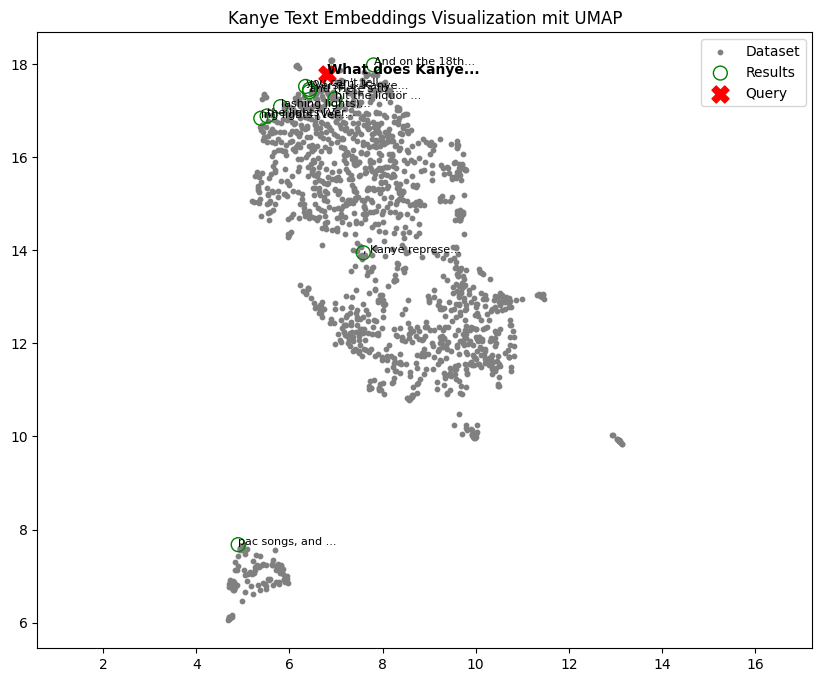


 Query: What does Kanye say about his Daughter North?

[1] Ähnlichkeitsabstand: 18.0234
Text:
[Verse 1: Kanye West] I met this girl when I was three years old And what I loved most, she had so much soul She said, "Excuse me, lil homie, I know you don't know me But my name is Windy and I like to blow trees." And from that point I never blow her off Niggas come from out of town, I like to show
------------------------------------------------------------
[2] Ähnlichkeitsabstand: 18.2353
Text:
pac songs, and speculated that association of the rapper to her brother allowed her to understand and appreciate his songs more. Now older, she found aspects of Kanye West's music resonating with her in similar ways to Tupac's. More specifically, she experi - enced West's contradictory persona, rife
------------------------------------------------------------
[3] Ähnlichkeitsabstand: 18.3127
Text:
, Kanye represents the voice inside us that pushes us to go beyond.FOREWORD FOREWORD If anyones reading

In [26]:
import umap
import matplotlib.pyplot as plt
import numpy as np

def shorten_text(text, max_length=15):
    return (text[:max_length] + '...') if len(text) > max_length else text

# 1. Fit UMAP auf alle Embeddings (nur einmal, wenn noch nicht geschehen)
reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine')
projected_dataset_embeddings = reducer.fit_transform(embeddings)  # embeddings = alle Chunks

# 2. Transformiere die Retrieval-Ergebnisse (retrieved embeddings)
projected_result_embeddings = reducer.transform(np.array(result_embeddings))

# 3. Transformiere Query-Embedding
query_embedding = model.encode([query], convert_to_numpy=True)
project_original_query = reducer.transform(query_embedding)

# 4. Plot
plt.figure(figsize=(10,8))

plt.scatter(projected_dataset_embeddings[:,0], projected_dataset_embeddings[:,1],
            s=10, color='gray', label='Dataset')

plt.scatter(projected_result_embeddings[:,0], projected_result_embeddings[:,1],
            s=100, facecolors='none', edgecolors='green', label='Results')

plt.scatter(project_original_query[:,0], project_original_query[:,1],
            s=150, marker='X', color='red', label='Query')

# Beschriftungen der Resultate
for i, text in enumerate(results):
    plt.annotate(shorten_text(text), 
                 (projected_result_embeddings[i,0], projected_result_embeddings[i,1]),
                 fontsize=8)

# Beschriftung der Query
plt.annotate(shorten_text(query), 
             (project_original_query[0,0], project_original_query[0,1]),
             fontsize=10, fontweight='bold')

plt.gca().set_aspect('equal', 'datalim')
plt.title('Kanye Text Embeddings Visualization mit UMAP')
plt.legend()
plt.show()

print(f"\n Query: {query}\n")

for i, (text, dist) in enumerate(zip(results, distances)):
    print(f"[{i+1}] Ähnlichkeitsabstand: {dist:.4f}")
    print(f"Text:\n{text[:300]}")  # max 300 Zeichen
    print("-" * 60)


## 1st Groq implementation


In [27]:
def build_prompt(context_chunks, user_query):
    context_block = "\n\n".join(context_chunks)
    prompt = f"""Answer the following question based on the given context.
 
context:
{context_block}
 
query:
{user_query}
 
answer:"""
    return prompt

In [28]:
from dotenv import load_dotenv
import os
from groq import Groq

load_dotenv(dotenv_path="env/.env")
groq_api_key = os.getenv("GROQ_API_KEY")
if groq_api_key is None:
    raise ValueError("API Key not found! Please check your env/.env file.")

client = Groq(api_key=groq_api_key)

# 2. List of user queries
user_queries = [
    "What are Kanye's main themes in his songs?",
    "How does Kanye West describe his relationship with his daughter?",
    "What role does religion play in Kanye's music?",
    "How does Kanye express himself about fashion and his influence on it?",
    "What does Kanye say about his career in the music business?",
    "What does Kanye say about his mental health?",
    "How does Kanye describe his artistic vision?",
    "What are Kanye's thoughts on American society?",
    "How does Kanye talk about his family and friends?",
    "What are Kanye's views on freedom and creativity?",
    "Why can't humans breathe underwater?" # hier erkannt, dass er rapt.
]


for user_query in user_queries:
    print(f"\n Frage: {user_query}")

    # 3Retrieve similar chunks
    retrieved_chunks, _, _ = retrieve(user_query, k=3)

    # 4. Build prompt
    prompt = build_prompt(retrieved_chunks, user_query)

    # 5. Groq Request
    response = client.chat.completions.create(
        model="llama3-70b-8192",
        messages=[
            {"role": "system", "content": "Du bist ein hilfsbereiter wissenschaftlicher Assistent."},
            {"role": "user", "content": prompt}
        ]
    )

    print(response.choices[0].message.content)


 Frage: What are Kanye's main themes in his songs?
Based on the context, Kanye's main themes in his songs appear to revolve around encouraging people to be themselves, embracing their imperfections, and striving to be more than what they are. His songs may also touch on creativity, self-esteem, love, and pushing boundaries.

 Frage: How does Kanye West describe his relationship with his daughter?
Actually, the text does not describe Kanye West's relationship with his daughter. The verse by Kanye West is about a girl named Windy, whom he met at the age of three, and not about his daughter.

 Frage: What role does religion play in Kanye's music?
Based on the provided context, there is no mention of religion playing a role in his music. The text primarily focuses on Kanye West's persona, music, and public perception, as well as comparisons to Tupac and the writer's personal experience with his music. If you'd like to discuss Kanye West's music and potential religious influences, I'd be h

### Off-Topic Filtering via Semantic Distance

In [29]:
from groq import Groq
import os
from dotenv import load_dotenv


def retrieve_with_validation(user_query, k=3, threshold=30.0):
    """
  Retrieves relevant chunks and checks whether they are semantically close enough to the query.
    Returns (chunks, is_valid).
    """
    chunks, _, distances = retrieve(user_query, k=k)

    if distances is None or len(distances) == 0:
        return [], False

    # Wenn distances 2D ist → auf erstes Ergebnis prüfen
    if isinstance(distances, np.ndarray) and distances.ndim == 2:
        max_distance = np.max(distances[0])
    elif isinstance(distances, (list, np.ndarray)):
        max_distance = np.max(distances)
    else:
        return [], False

    if max_distance > threshold:
        print(f"Max-Distanz {max_distance:.2f} → Off-topic")
        return [], False

    return chunks, True



load_dotenv(dotenv_path="env/.env")
groq_api_key = os.getenv("GROQ_API_KEY")
if groq_api_key is None:
    raise ValueError("API Key not found! Please check your env/.env file.")

client = Groq(api_key=groq_api_key)

# 2. List of user queries
user_queries = [
    "What are Kanye's main themes in his songs?",
    "How does Kanye West describe his relationship with his daughter?",
    "What role does religion play in Kanye's music?",
    "How does Kanye express himself about fashion and his influence on it?",
    "What does Kanye say about his career in the music business?",
    "What does Kanye say about his mental health?",
    "How does Kanye describe his artistic vision?",
    "What are Kanye's thoughts on American society?",
    "How does Kanye talk about his family and friends?",
    "What are Kanye's views on freedom and creativity?",
    "Why can't humans breathe underwater?"  # hier erkannt, dass er rapt.
]
for user_query in user_queries:
    retrieved_chunks, is_valid = retrieve_with_validation(user_query, k=3)

    if not is_valid:
        print(f"\n Skipping off-topic query: {user_query}")
        continue

    print(f"\Question: {user_query}")

    prompt = build_prompt(retrieved_chunks, user_query)

    response = client.chat.completions.create(
        model="llama3-70b-8192",
        messages=[
            {"role": "system", "content": "Du bist ein hilfsbereiter wissenschaftlicher Assistent."},
            {"role": "user", "content": prompt}
        ]
    )

    print(response.choices[0].message.content)

\Question: What are Kanye's main themes in his songs?
Based on the provided context, it doesn't explicitly mention his main themes in his songs. However, it does provide some hints through the chapter titles, which might give us an idea about the topics he frequently talks about in his songs:

* "Kanye on Life"
* "Kanye on Art"
* "Kanye on Creative Process"
* "Kanye on Collaboration"
* "Kanye on Music"
* "Kanye on Hip-Hop"
* "Kanye on Love"
* "Kanye on Self Esteem"
* "Kanye on Creativity"
* "Kanye on Clothes"

From these chapter titles, we can infer that Kanye's main themes in his songs might revolve around:

1. Self-empowerment and self-esteem
2. Creativity and the creative process
3. Love and relationships
4. His experiences and views on life
5. Artistic expression and art
6. Hip-hop and music
7. Collaboration and working with others
8. Fashion and style (represented by "Kanye on Clothes")

Keep in mind that this is not a definitive answer, as the context doesn't provide direct infor

## Expansion 

In [30]:
def expand_query_llm(user_query):
    expansion_prompt = f"""
You are an intelligent assistant specialized in semantic search.

You are helping a researcher analyze Kanye West by expanding their search queries. 
The research corpus includes:
- Kanye West's tweets (raw and emotional expressions)
- Song lyrics (poetic, metaphorical content)
- A detailed biography (life events and personal struggles)
- A psychoanalytic academic study (interpretive analysis)
- A quote-based book about Kanye West's philosophies

The researcher is trying to understand Kanye from psychological, cultural, and artistic perspectives. 
Your task is to reformulate the given user query into 3 semantically related queries 
that explore slightly different but relevant angles — potentially using different vocabulary, focus, or conceptual framing.

Original query: "{user_query}"

Please output only the three reformulated queries as a list.
"""
    response = client.chat.completions.create(
        model="llama3-70b-8192",
        messages=[{"role": "user", "content": expansion_prompt}]
    )

    return [q.strip("- ").strip() for q in response.choices[0].message.content.split("\n") if q.strip()]


In [31]:
def retrieve_with_expansion(user_query, k=10):
    expanded_queries = expand_query_llm(user_query)
    queries = [user_query] + expanded_queries

    all_chunks_expanded = []
    seen_texts = set()

    for q in queries:
        chunks, _, _ = retrieve(q, k=5)  # your FAISS-based retrieval function
        for chunk in chunks:
            if chunk not in seen_texts:
                all_chunks_expanded.append(chunk)
                seen_texts.add(chunk)
            if len(all_chunks_expanded) >= k:
                break
        if len(all_chunks_expanded) >= k:
            break

    return all_chunks_expanded


In [32]:
for user_query in user_queries:
    print(f"\n Original Question: {user_query}")

    # Step 1: Retrieve context using semantically expanded queries
    retrieved_chunks = retrieve_with_expansion(user_query, k=5)

    # Step 2: Build prompt based on retrieved context and original query
    prompt = build_prompt(retrieved_chunks, user_query)

    # Step 3: Call LLM for answer generation
    response = client.chat.completions.create(
        model="llama3-70b-8192",
        messages=[
            {
                "role": "system",
                "content": """
You are a helpful academic assistant specializing in cultural, psychological, and artistic analysis.

The user is researching Kanye West using a diverse corpus that includes:
- Raw Tweets
- Song lyrics
- A detailed biography
- A psychoanalytic academic study
- A quote-based philosophy book

You interpret the retrieved context in depth and answer the user's question with analytical insight, drawing connections across sources. 
Focus on psychological, societal, and artistic meaning where appropriate. Be concise but thoughtful.
""" 
            },
            {"role": "user", "content": prompt}
        ]
    )

    print(f"\n Answer:\n{response.choices[0].message.content}")



 Original Question: What are Kanye's main themes in his songs?

 Answer:
Based on the provided context, Kanye West's main themes in his songs can be deduced as follows:

1. **Self-empowerment and perseverance**: Kanye's lyrics often convey a sense of determination and perseverance in the face of adversity. For instance, in the provided lyrics, "We in the streets, playa, get ya mail / It's only two places you end up, either dead or in jail" suggest a harsh reality, but the tone is more uplifting than despairing. This theme is closely tied to Kanye's personal narrative, where he has consistently pushed against the odds to achieve success.

2. **Societal commentary and critique**: Kanye's lyrics often touch upon societal issues, such as racism, class disparities, and the struggles faced by marginalized communities. For example, the verse "Two words, United States, no breaks / Low brow, high stakes, crack smoke, black folks" critiques the systemic injustices faced by African Americans.

3

## Gradio (Draft)

In [33]:
import gradio as gr
from PIL import Image

# Hauptfunktion für die UI
def kanye_rag_interface(user_query):
    chunks, is_valid = retrieve_with_validation(user_query, k=5)
    if not is_valid:
        return "Diese Frage scheint nicht zum Kanye-Kontext zu passen."

    prompt = build_prompt(chunks, user_query)
    response = client.chat.completions.create(
        model="llama3-70b-8192",
        messages=[
            {"role": "system", "content": "Du bist ein hilfsbereiter Assistent mit Fokus auf Kultur, Psychologie & Kunst."},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message.content

# UI bauen
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    with gr.Column():
        gr.Image("kanye.jpeg", show_label=False, container=False, elem_id="kanye-img")

        gr.Markdown("##  **KanyeRAG** – Kontextuelles Fragen an Kanye")
        gr.Markdown(" Ein semantisches RAG-System basierend auf Lyrics, Tweets, Biografie, Studien & Zitaten – powered by FAISS & LLaMA3")

    with gr.Row():
        user_input = gr.Textbox(lines=2, label="Deine Frage", placeholder="z.B. Was sagt Kanye über mentale Gesundheit?")
        submit_btn = gr.Button("Antwort generieren")

    result = gr.Textbox(label=" Antwort", lines=8)

    with gr.Accordion(" Beispiel-Fragen", open=False):
        gr.Markdown("""
        - Was denkt Kanye über Kreativität?
        - Welche Bedeutung hat Gott für Kanye?
        - Welche Rolle spielt seine Bipolarität?
        - Wie spricht Kanye über seine Kindheit?
        - Warum kann der Mensch nicht unter Wasser atmen?
        """)

    submit_btn.click(fn=kanye_rag_interface, inputs=user_input, outputs=result)

# App starten
demo.launch()


* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.
